In [1]:
#The goal is to predict Leq (noise level in dBA) using inputs like vehicle capacity (PCU), speed, flow type

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  
import seaborn as sns

In [3]:
# Load sheets
file_path = 'data\\FINAL DATA.xlsx'  # Update to your actual path
df_leq = pd.read_excel(file_path, sheet_name='Noise Leq Data')
df_speed = pd.read_excel(file_path, sheet_name='SPEED')
df_pcu = pd.read_excel(file_path, sheet_name='PCU')
df_pcu_conv = pd.read_excel(file_path, sheet_name='PCU Conversion')  # For vehicle counts

# Modified data processing to extract vehicle categories like the paper
data = []
places = df_leq['Place'].dropna().unique()
hours = ['6-7AM', '7-8AM', '8-9AM', '9-10AM', '10-11AM', '11-12PM', '12-1PM', '1-2PM', '2-3PM', '3-4PM', '4-5PM', '5-6PM']

lanes_dict = {
    'Around Arya School': 2,  # Ngara Arya
    'Around Baba Dogo Rd': 2,
    'Around Junction Mall': 4,
    'Around Langata Hospital': 4,
    'Around MMU': 4,
    'BBS Eastleigh': 4,
    'Bee Centre': 2,
    'Close to Uhuru Park': 2,
    'Davis&Shirtliff Kangundo Rd': 2,
    'ICD Road': 4,
    'Imaara Mall': 4,
    'Jevanjee': 2,
    'Jogoo Road': 4,
    'Kangemi': 4,
    'Karen C School': 2,
    'Kawangware': 2,
    'KCB Utawala Eastern Bypass': 4,
    'KFC Embakasi': 4,
    'Kiambu Road': 2,
    'Kiambu Road 2': 2,
    'Kinoo': 2,
    'Langata Link Road': 4,
    'Likoni Road': 4,
    'Makongeni Shopping Centre Ruai': 2,
    'Ngong Road': 4,
    'Northern Bypass': 2,
    'Nyayo Langata': 4,
    'Ola Energy Waiyaki Way': 8,
    'Opp. KU Hospital': 2,
    'Quality Meat Packers': 2,
    'Raila Odinga Road Next to Total': 4,
    'Ruaka': 2,
    'Runda': 2,
    'Southern Bypass 1': 4,
    'Southern Bypass 2': 4,
    'Thika Road 1': 8,
    'Thika Road 2': 8,
    'Thika Road (Pangani)': 8,
    'Thome': 2,
    'Total Energies Outering': 8,
    'Winners Chapel (Likoni Road)': 4,
    'Junction Mall': 4,
    'Arya (Ngara)': 2,
    'Around Baba Dogo Road': 2
}

for i, place in enumerate(places):
    leq_row = df_leq.iloc[i, 2:].values  # Leq per hour
    speed_row = df_speed.iloc[i, 2:].values  # Speed per hour
    pcu_row = df_pcu.iloc[i, 2:].values  # PCU per hour
    
    # Get vehicle categories from PCU Conversion
    place_conv = df_pcu_conv[df_pcu_conv['Place'].str.strip().str.upper() == place.strip().upper()]
    if not place_conv.empty:
        conv_row = place_conv.iloc[0, 3:].values  # Start from 'Bicycle' column
        vehicle_cols = df_pcu_conv.columns[3:]  # Columns from 'Bicycle' onward
        
        # Extract vehicle counts (handle missing columns with defaults)
        motorcycles = conv_row[list(vehicle_cols).index('Motorcycles')] if 'Motorcycles' in vehicle_cols else 0
        light_cols = ['Private car', 'Pickup', 'SUV']  # Define light vehicle categories
        light_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in light_cols if col in vehicle_cols)
        medium_cols = ['Buses', 'Light trucks']  # Define medium vehicle categories
        medium_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in medium_cols if col in vehicle_cols)
        heavy_cols = ['Medium trucks', 'Heavy trucks']  # Define heavy vehicle categories
        heavy_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in heavy_cols if col in vehicle_cols)
        
        # Convert NaN to 0
        motorcycles = 0 if pd.isna(motorcycles) else motorcycles
        light_vehicles = 0 if pd.isna(light_vehicles) else light_vehicles
        medium_vehicles = 0 if pd.isna(medium_vehicles) else medium_vehicles
        heavy_vehicles = 0 if pd.isna(heavy_vehicles) else heavy_vehicles
    else:
        motorcycles = light_vehicles = medium_vehicles = heavy_vehicles = 0
    
    lanes = lanes_dict.get(place, 2)
    
    # Process each hour
    for h, hour in enumerate(hours):
        if pd.notna(leq_row[h]) and pd.notna(speed_row[h]) and pd.notna(pcu_row[h]):
            current_speed = speed_row[h]
            
            # Flow type based on speed (like paper's traffic condition)
            if current_speed < 20:
                flow_type = 0  # Congested
            elif current_speed < 35:
                flow_type = 1  # Periodic
            else:
                flow_type = 2  # Fluid
            
            data.append({
                'place': place,
                'motorcycles': motorcycles,
                'light': light_vehicles,
                'medium': medium_vehicles,
                'heavy': heavy_vehicles,
                'speed': current_speed,
                'lanes': lanes,
                'flow_type': flow_type,
                'leq': leq_row[h]
            })

df = pd.DataFrame(data)
df = df.dropna()
print("New feature set shape:", df.shape)
print("Features:", df.columns.tolist())

New feature set shape: (504, 9)
Features: ['place', 'motorcycles', 'light', 'medium', 'heavy', 'speed', 'lanes', 'flow_type', 'leq']


In [4]:
# NEW: Features exactly like the paper
features = ['motorcycles', 'light', 'medium', 'heavy', 'speed', 'lanes', 'flow_type']  # 7 features like paper
target = 'leq'

X = df[features].values
y = df[target].values

print(f"Input shape: {X.shape}")  # Should be (n_samples, 7)
print(f"Target shape: {y.shape}")

Input shape: (504, 7)
Target shape: (504,)


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data first (paper used 75/25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features (paper mentions this was important)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class NoisePredictor(nn.Module):
    def __init__(self, input_dim):
        super(NoisePredictor, self).__init__()
        # EXACT paper architecture: 7 -> 26 -> 1
        self.fc1 = nn.Linear(input_dim, 26)  # Paper used 26 neurons
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # Paper used tanh activation
        return self.fc2(x)  # No activation on output (regression)

# Initialize with 7 inputs (like paper)
input_dim = 7
model = NoisePredictor(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NoisePredictor(
  (fc1): Linear(in_features=7, out_features=26, bias=True)
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Load sheets
file_path = 'data\\FINAL DATA.xlsx'
df_leq = pd.read_excel(file_path, sheet_name='Noise Leq Data')
df_speed = pd.read_excel(file_path, sheet_name='SPEED')
df_pcu = pd.read_excel(file_path, sheet_name='PCU')
df_pcu_conv = pd.read_excel(file_path, sheet_name='PCU Conversion')  # For vehicle counts

data = []
places = df_leq['Place'].dropna().unique()
hours = ['6-7AM', '7-8AM', '8-9AM', '9-10AM', '10-11AM', '11-12PM', '12-1PM', '1-2PM', '2-3PM', '3-4PM', '4-5PM', '5-6PM']

lanes_dict = {
    'Around Arya School': 2, 
    'Around Baba Dogo Rd': 2,
    'Around Junction Mall': 4,
    'Around Langata Hospital': 4,
    'Around MMU': 4,
    'BBS Eastleigh': 4,
    'Bee Centre': 2,
    'Close to Uhuru Park': 2,
    'Davis&Shirtliff Kangundo Rd': 2,
    'ICD Road': 4,
    'Imaara Mall': 4,
    'Jevanjee': 2,
    'Jogoo Road': 4,
    'Kangemi': 4,
    'Karen C School': 2,
    'Kawangware': 2,
    'KCB Utawala Eastern Bypass': 4,
    'KFC Embakasi': 4,
    'Kiambu Road': 2,
    'Kiambu Road 2': 2,
    'Kinoo': 2,
    'Langata Link Road': 4,
    'Likoni Road': 4,
    'Makongeni Shopping Centre Ruai': 2,
    'Ngong Road': 4,
    'Northern Bypass': 2,
    'Nyayo Langata': 4,
    'Ola Energy Waiyaki Way': 8,
    'Opp. KU Hospital': 2,
    'Quality Meat Packers': 2,
    'Raila Odinga Road Next to Total': 4,
    'Ruaka': 2,
    'Runda': 2,
    'Southern Bypass 1': 4,
    'Southern Bypass 2': 4,
    'Thika Road 1': 8,
    'Thika Road 2': 8,
    'Thika Road (Pangani)': 8,
    'Thome': 2,
    'Total Energies Outering': 8,
    'Winners Chapel (Likoni Road)': 4,
    'Junction Mall': 4,
    'Arya (Ngara)': 2,
    'Around Baba Dogo Road': 2
}

for i, place in enumerate(places):
    leq_row = df_leq.iloc[i, 2:].values  # Leq per hour
    speed_row = df_speed.iloc[i, 2:].values  # Speed per hour
    pcu_row = df_pcu.iloc[i, 2:].values  # PCU per hour
    
    # Get vehicle categories from PCU Conversion
    place_conv = df_pcu_conv[df_pcu_conv['Place'].str.strip().str.upper() == place.strip().upper()]
    if not place_conv.empty:
        conv_row = place_conv.iloc[0, 3:].values  # Start from 'Bicycle' column
        vehicle_cols = df_pcu_conv.columns[3:]
        
        motorcycles = conv_row[list(vehicle_cols).index('Motorcycles')] if 'Motorcycles' in vehicle_cols else 0
        light_cols = ['Private car', 'Pickup', 'SUV']
        light_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in light_cols if col in vehicle_cols)
        medium_cols = ['Buses', 'Light trucks']
        medium_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in medium_cols if col in vehicle_cols)
        heavy_cols = ['Medium trucks', 'Heavy trucks']
        heavy_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in heavy_cols if col in vehicle_cols)
        
        motorcycles = 0 if pd.isna(motorcycles) else motorcycles
        light_vehicles = 0 if pd.isna(light_vehicles) else light_vehicles
        medium_vehicles = 0 if pd.isna(medium_vehicles) else medium_vehicles
        heavy_vehicles = 0 if pd.isna(heavy_vehicles) else heavy_vehicles
    else:
        motorcycles = light_vehicles = medium_vehicles = heavy_vehicles = 0
    
    lanes = lanes_dict.get(place, 2)
    
    for h, hour in enumerate(hours):
        if pd.notna(leq_row[h]) and pd.notna(speed_row[h]) and pd.notna(pcu_row[h]):
            current_speed = speed_row[h]
            
            if current_speed < 20:
                flow_type = 0  # Congested
            elif current_speed < 35:
                flow_type = 1  # Periodic
            else:
                flow_type = 2  # Fluid
            
            data.append({
                'place': place,
                'motorcycles': motorcycles,
                'light': light_vehicles,
                'medium': medium_vehicles,
                'heavy': heavy_vehicles,
                'speed': current_speed,
                'lanes': lanes,
                'flow_type': flow_type,
                'leq': leq_row[h]
            })

df = pd.DataFrame(data)
df = df.dropna()

# Features and target
features = ['motorcycles', 'light', 'medium', 'heavy', 'speed', 'lanes', 'flow_type'] 
target = 'leq'

X = df[features].values
y = df[target].values

print(f"Input shape: {X.shape}")  
print(f"Target shape: {y.shape}")  

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paper-style model
class NoisePredictorPaper(nn.Module):
    def __init__(self, input_dim):
        super(NoisePredictorPaper, self).__init__()
        self.fc1 = nn.Linear(input_dim, 26)
        self.fc2 = nn.Linear(26, 1)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return self.fc2(x)

input_dim = X.shape[1]  # 7 features
model = NoisePredictorPaper(input_dim).to(device)

# Training function
def train_predictor_paper_style(model, train_dl, test_dl, num_epochs=10000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Paper uses SGD, Adam
    train_losses = []
    val_maes = []
    best_mae = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            val_preds, val_trues = [], []
            with torch.no_grad():
                for inputs, targets in test_dl:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    val_preds.extend(outputs.cpu().numpy().flatten())
                    val_trues.extend(targets.numpy().flatten())
            
            val_mae = mean_absolute_error(val_trues, val_preds)
            train_losses.append(train_loss / len(train_dl))
            val_maes.append(val_mae)
            
            if val_mae < best_mae:
                best_mae = val_mae
            
            print(f'Epoch {epoch}: Train Loss {train_losses[-1]:.4f}, Val MAE {val_mae:.3f} dBA')
    
    return train_losses, val_maes, model

# Train the model
train_losses, val_maes, trained_model = train_predictor_paper_style(model, train_dl, test_dl)





Input shape: (504, 7)
Target shape: (504,)
Epoch 0: Train Loss 2544.9357, Val MAE 12.897 dBA
Epoch 10: Train Loss 12.1014, Val MAE 2.985 dBA
Epoch 20: Train Loss 11.9561, Val MAE 2.996 dBA
Epoch 30: Train Loss 11.9927, Val MAE 2.922 dBA
Epoch 40: Train Loss 11.6146, Val MAE 2.928 dBA
Epoch 50: Train Loss 11.6211, Val MAE 2.931 dBA
Epoch 60: Train Loss 11.1550, Val MAE 2.850 dBA
Epoch 70: Train Loss 10.7385, Val MAE 2.860 dBA
Epoch 80: Train Loss 10.5714, Val MAE 2.834 dBA
Epoch 90: Train Loss 10.3690, Val MAE 2.792 dBA
Epoch 100: Train Loss 10.1942, Val MAE 2.794 dBA
Epoch 110: Train Loss 10.1740, Val MAE 2.796 dBA
Epoch 120: Train Loss 10.1157, Val MAE 2.794 dBA
Epoch 130: Train Loss 9.8488, Val MAE 2.720 dBA
Epoch 140: Train Loss 9.7888, Val MAE 2.733 dBA
Epoch 150: Train Loss 9.7360, Val MAE 2.775 dBA
Epoch 160: Train Loss 10.0606, Val MAE 2.758 dBA
Epoch 170: Train Loss 9.6638, Val MAE 2.703 dBA
Epoch 180: Train Loss 9.6997, Val MAE 2.759 dBA
Epoch 190: Train Loss 9.4973, Val MAE 2

In [8]:
# Evaluation function
def evaluate_paper_style(model, test_dl):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy().flatten())
            trues.extend(targets.numpy().flatten())
    
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    
    print(f'Paper-Style Results:')
    print(f'MAE: {mae:.2f} dBA (Paper: 0.86 dBA)')
    print(f'RMSE: {rmse:.2f} dBA (Paper: 1.14 dBA)')
    print(f'R²: {r2:.2f} (Paper: 0.88)')
    
    return mae, r2, preds, trues, rmse

mae, r2, preds, trues, rmse = evaluate_paper_style(trained_model, test_dl)

Paper-Style Results:
MAE: 1.38 dBA (Paper: 0.86 dBA)
RMSE: 1.68 dBA (Paper: 1.14 dBA)
R²: 0.85 (Paper: 0.88)


In [9]:
# Prediction function for a specific location
def predict_leq_for_place(model, scaler, place, lanes_dict, speed=None, flow_type=None):
    # Map place to lanes
    lanes = lanes_dict.get(place, 2)
    
    # Use default or user-provided values for other features
    if speed is None:
        speed = float(input(f"Enter average speed (km/h) for {place} [e.g., 30]: ") or 30)
    if flow_type is None:
        flow_type = 1 if 20 <= speed < 35 else 0 if speed < 20 else 2  # Default based on speed
    
    # Assume vehicle counts based on existing data (or prompt user)
    # For now, use mean values from training data as a placeholder
    mean_features = np.array([df['motorcycles'].mean(), df['light'].mean(), df['medium'].mean(),
                             df['heavy'].mean(), speed, lanes, flow_type]).reshape(1, -1)
    scaled_features = scaler.transform(mean_features)
    
    # Predict
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        prediction = model(input_tensor).cpu().numpy().flatten()[0]
    
    print(f"Predicted Leq for {place}: {prediction:.2f} dBA")
    return prediction

# Example usage
place_to_predict = input("Enter a location (e.g., Imaara Mall): ")
predict_leq_for_place(trained_model, scaler, place_to_predict, lanes_dict)

Predicted Leq for imaara mall: 68.71 dBA


np.float32(68.70616)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Apply logarithmic transformations to features as per the paper's MLR approach
# Add 1 to avoid log(0) issues for counts and speed
X_train_log = np.log1p(df[features].iloc[:len(X_train)])
X_test_log = np.log1p(df[features].iloc[len(X_train):])

# Fit Multiple Linear Regression model
reg = LinearRegression().fit(X_train_log, y_train)

# Predict using the test set
preds_lr = reg.predict(X_test_log)

# Calculate metrics
mae_lr = mean_absolute_error(y_test, preds_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, preds_lr))
r2_lr = r2_score(y_test, preds_lr)

# Print results
print(f'lr MAE: {mae_lr:.2f} dBA')
print(f'lr RMSE: {rmse_lr:.2f} dBA')
print(f'lr R²: {r2_lr:.2f}')

lr MAE: 3.74 dBA
lr RMSE: 4.44 dBA
lr R²: -0.07


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
r2_rf = r2_score(y_test, preds_rf)

# Print results
print(f'Random Forest MAE: {mae_rf:.2f} dBA')
print(f'Random Forest RMSE: {rmse_rf:.2f} dBA')
print(f'Random Forest R²: {r2_rf:.2f}')

Random Forest MAE: 1.09 dBA
Random Forest RMSE: 1.43 dBA
Random Forest R²: 0.89


In [12]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)
preds_svr = svr.predict(X_test)

# Calculate metrics
mae_svr = mean_absolute_error(y_test, preds_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, preds_svr))
r2_svr = r2_score(y_test, preds_svr)

# Print results
print(f'SVR MAE: {mae_svr:.2f} dBA')
print(f'SVR RMSE: {rmse_svr:.2f} dBA')
print(f'SVR R²: {r2_svr:.2f}')

SVR MAE: 2.67 dBA
SVR RMSE: 3.59 dBA
SVR R²: 0.30


In [13]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
preds_xgb = xgb_model.predict(X_test)

# Calculate metrics
mae_xgb = mean_absolute_error(y_test, preds_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
r2_xgb = r2_score(y_test, preds_xgb)

# Print results
print(f'XGBoost MAE: {mae_xgb:.2f} dBA')
print(f'XGBoost RMSE: {rmse_xgb:.2f} dBA')
print(f'XGBoost R²: {r2_xgb:.2f}')

XGBoost MAE: 1.14 dBA
XGBoost RMSE: 1.39 dBA
XGBoost R²: 0.89


In [14]:
from torch.nn import LSTM
class NoiseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NoiseLSTM, self).__init__()
        self.lstm = LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
# Requires reshaping X into (samples, timesteps, features)

In [15]:
torch.save(model.state_dict(), 'noise_predictor_model.pth')

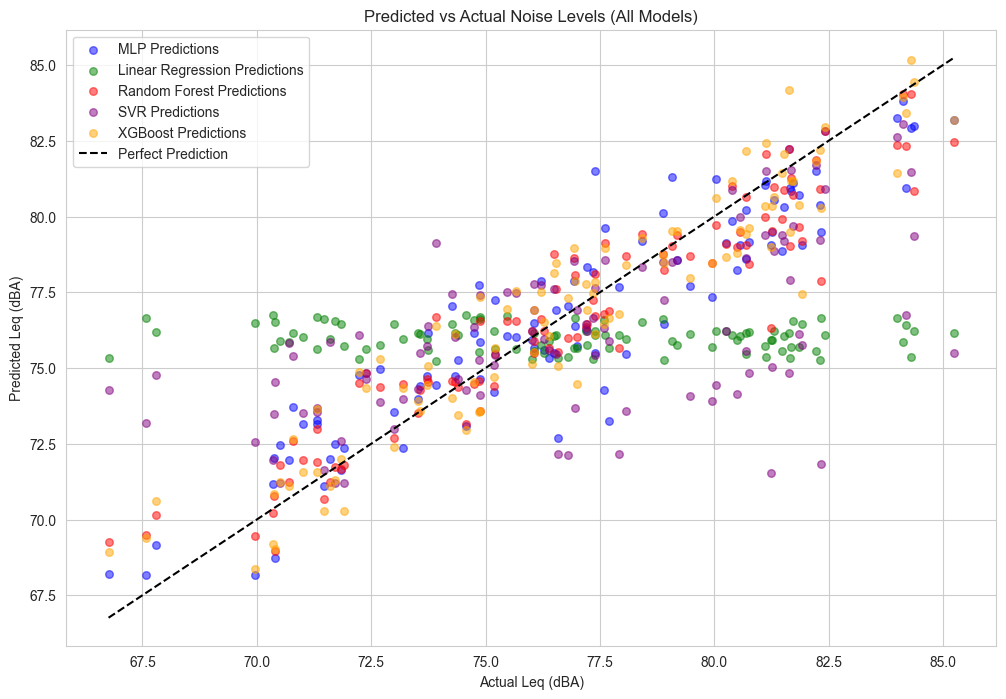

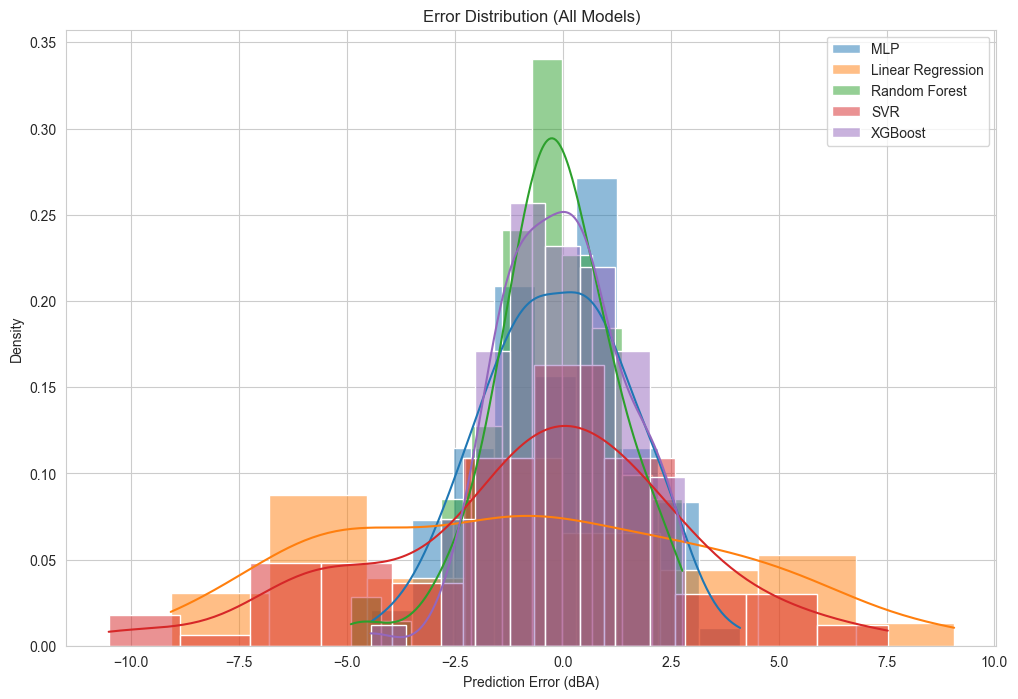

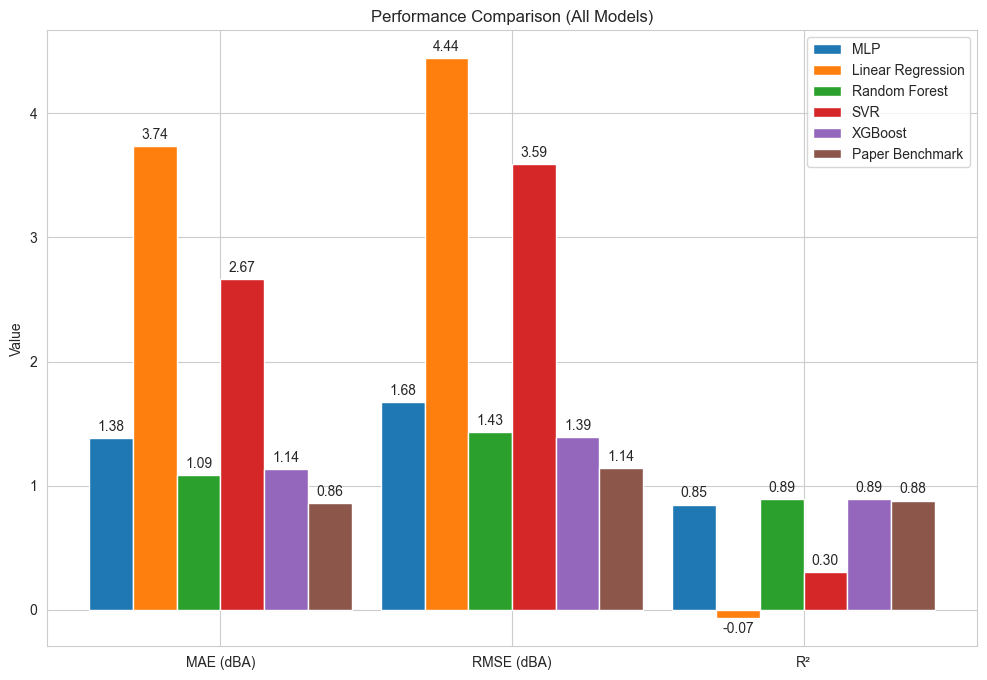

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Set seaborn style for paper-like aesthetics
sns.set_style("whitegrid")

# 1. Training Loss over Epochs (MLP only)
#plt.figure(figsize=(10, 6))
#plt.plot(range(0, len(train_losses) * 10, 10), train_losses, label='Training Loss (MLP)', color='blue')
#plt.xlabel('Epochs')
#plt.ylabel('MSE Loss')
#plt.title('Training Loss over Epochs (MLP)')
#plt.legend()
#plt.savefig('training_loss_plot.png')  # Save for report inclusion
#plt.show()

# 2. Predicted vs Actual Noise Levels (Scatter Plot for all models)
plt.figure(figsize=(12, 8))
models = ['MLP', 'Linear Regression', 'Random Forest', 'SVR', 'XGBoost']
predictions = [preds, preds_lr, preds_rf, preds_svr, preds_xgb]
colors = ['blue', 'green', 'red', 'purple', 'orange']

for pred, model, color in zip(predictions, models, colors):
    plt.scatter(trues, pred, alpha=0.5, label=f'{model} Predictions', color=color, s=30)
plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Leq (dBA)')
plt.ylabel('Predicted Leq (dBA)')
plt.title('Predicted vs Actual Noise Levels (All Models)')
plt.legend()
plt.savefig('predicted_vs_actual_plot_all.png')  # Save for report inclusion
plt.show()

# 3. Error Distribution Histogram (for all models)
plt.figure(figsize=(12, 8))
errors = {model: np.array(pred) - trues for model, pred in zip(models, predictions)}
for model, err in errors.items():
    sns.histplot(err, kde=True, label=model, alpha=0.5, stat='density', common_norm=False)
plt.xlabel('Prediction Error (dBA)')
plt.ylabel('Density')
plt.title('Error Distribution (All Models)')
plt.legend()
plt.savefig('error_distribution_plot_all.png')  # Save for report inclusion
plt.show()

# 4. Performance Comparison Bar Chart (for all models)
metrics = ['MAE (dBA)', 'RMSE (dBA)', 'R²']
model_values = {
    'MLP': [mae, rmse, r2],
    'Linear Regression': [mae_lr, rmse_lr, r2_lr],
    'Random Forest': [mae_rf, rmse_rf, r2_rf],
    'SVR': [mae_svr, rmse_svr, r2_svr],
    'XGBoost': [mae_xgb, rmse_xgb, r2_xgb],
    'Paper Benchmark': [0.86, 1.14, 0.88]
}
# Ensure rmse_lr and r2_lr are calculated if not already (using preds_lr for consistency)
if 'rmse_lr' not in locals() or 'r2_lr' not in locals():
    rmse_lr = np.sqrt(mean_squared_error(y_test, preds_lr))
    r2_lr = r2_score(y_test, preds_lr)
    model_values['Linear Regression'] = [mae_lr, rmse_lr, r2_lr]

x = np.arange(len(metrics))
width = 0.15
fig, ax = plt.subplots(figsize=(12, 8))

for i, (model, values) in enumerate(model_values.items()):
    offset = width * (i - len(model_values) / 2 + 0.5)
    rects = ax.bar(x + offset, values, width, label=model)

ax.set_ylabel('Value')
ax.set_title('Performance Comparison (All Models)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

for rects in ax.containers:
    ax.bar_label(rects, padding=3, fmt='%.2f')

plt.savefig('performance_comparison_plot_all.png')  # Save for report inclusion
plt.show()

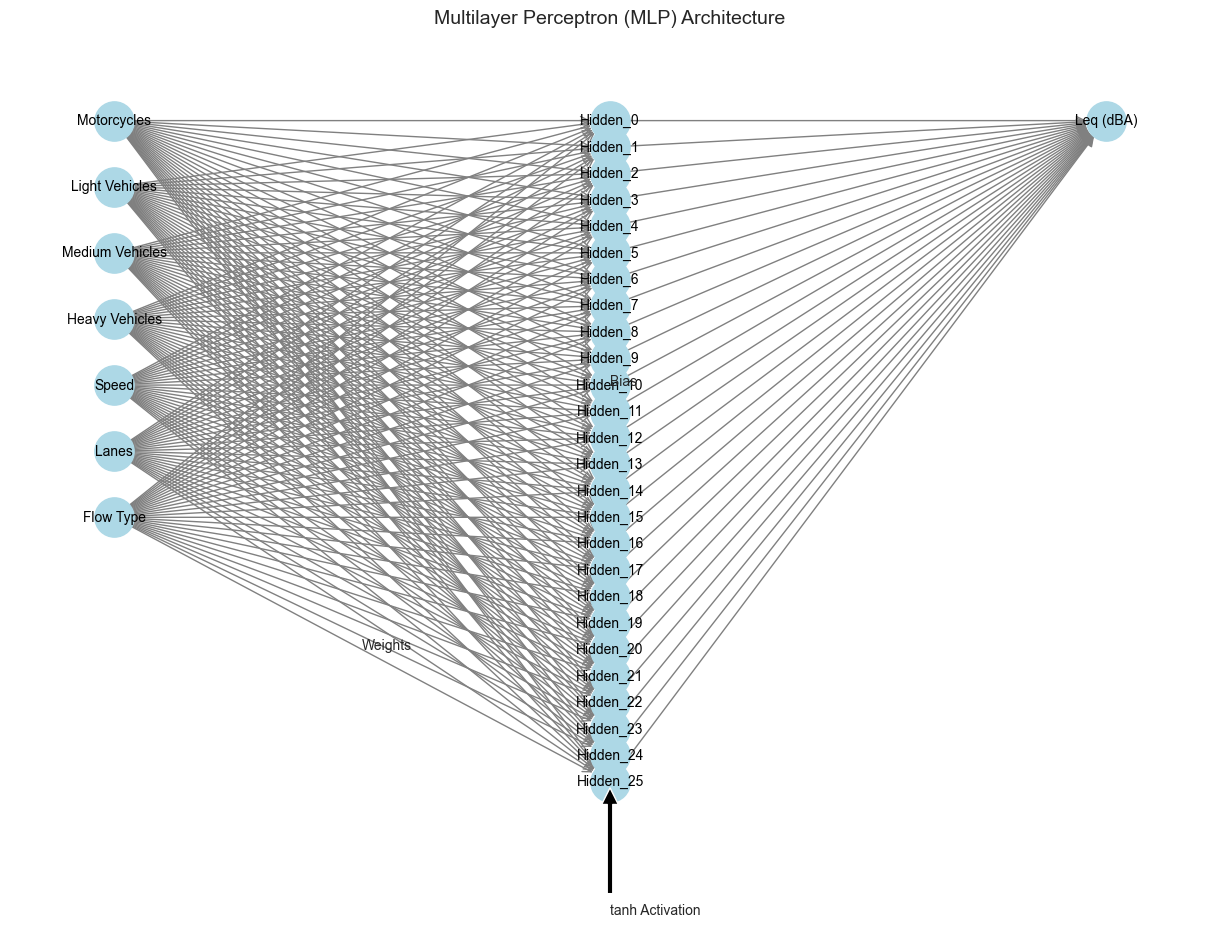

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes with meaningful labels
input_nodes = ["Motorcycles", "Light Vehicles", "Medium Vehicles", "Heavy Vehicles", "Speed", "Lanes", "Flow Type"]
hidden_nodes = [f"Hidden_{i}" for i in range(26)]
output_node = ["Leq (dBA)"]

# Add nodes to graph
G.add_nodes_from(input_nodes)
G.add_nodes_from(hidden_nodes)
G.add_node(output_node[0])

# Add edges (fully connected)
for i in input_nodes:
    for h in hidden_nodes:
        G.add_edge(i, h)
for h in hidden_nodes:
    G.add_edge(h, output_node[0])

# Position nodes left to right with adjusted spacing
pos = {}
# Input layer (x=1, spread vertically)
pos.update((node, (1, -i * 0.5)) for i, node in enumerate(input_nodes))
# Hidden layer (x=2, spread vertically with scaling)
pos.update((node, (2, -i * 0.2)) for i, node in enumerate(hidden_nodes))
# Output layer (x=3, centered)
pos.update([(output_node[0], (3, 0))])  # Fixed line

# Draw graph with enhanced aesthetics
plt.figure(figsize=(12, 8))  # Increased size for better visibility
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=10, 
        arrows=True, arrowstyle='->', arrowsize=15, edge_color='gray')
plt.title("Multilayer Perceptron (MLP) Architecture", fontsize=14, pad=20)
plt.annotate("tanh Activation", xy=(2, -5), xytext=(2, -6), fontsize=10,
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Weights", xy=(1.5, -3), xytext=(1.5, -4), fontsize=10)
plt.annotate("Bias", xy=(2, -1), xytext=(2, -2), fontsize=10)
plt.axis('off')  # Hide axes for cleaner look
plt.savefig("ann_diagram.png", dpi=300, bbox_inches='tight')  # Higher DPI for quality
plt.show()

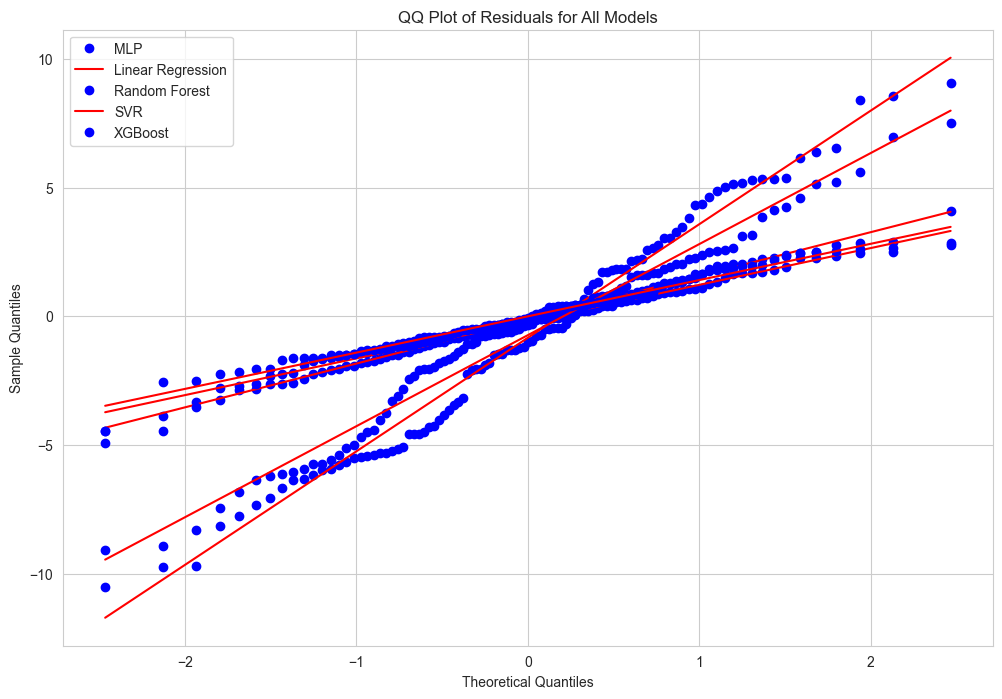

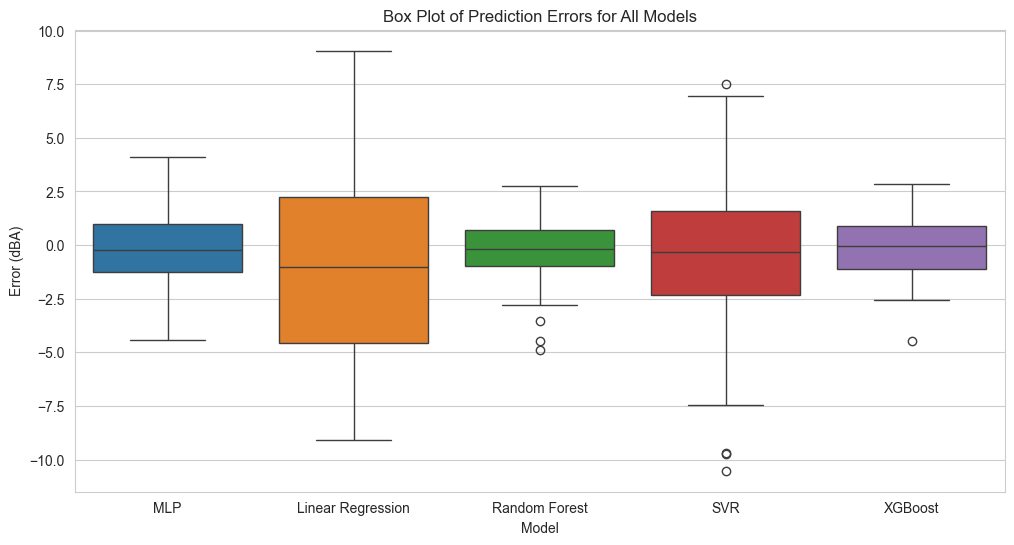

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming these variables are defined from previous model runs
models = ['MLP', 'Linear Regression', 'Random Forest', 'SVR', 'XGBoost']
predictions = [preds, preds_lr, preds_rf, preds_svr, preds_xgb]
trues = y_test  # Actual values

# Calculate errors for each model
errors = {model: np.array(pred) - trues for model, pred in zip(models, predictions)}

# QQ Plot
plt.figure(figsize=(12, 8))
for model, err in errors.items():
    stats.probplot(err, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals for All Models')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend(models)
plt.savefig('qq_plot_all.png')
plt.show()

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(errors))
plt.title('Box Plot of Prediction Errors for All Models')
plt.xlabel('Model')
plt.ylabel('Error (dBA)')
plt.savefig('box_plot_errors.png')
plt.show()

Performance Comparison with CoRTN:
MLP: MAE = 1.38 dBA, RMSE = 1.68 dBA, R² = 0.85
Linear Regression: MAE = 3.74 dBA, RMSE = 4.44 dBA, R² = -0.07
Random Forest: MAE = 1.09 dBA, RMSE = 1.43 dBA, R² = 0.89
SVR: MAE = 2.67 dBA, RMSE = 3.59 dBA, R² = 0.30
XGBoost: MAE = 1.14 dBA, RMSE = 1.39 dBA, R² = 0.89
CoRTN: MAE = 5.43 dBA, RMSE = 6.79 dBA, R² = -1.50


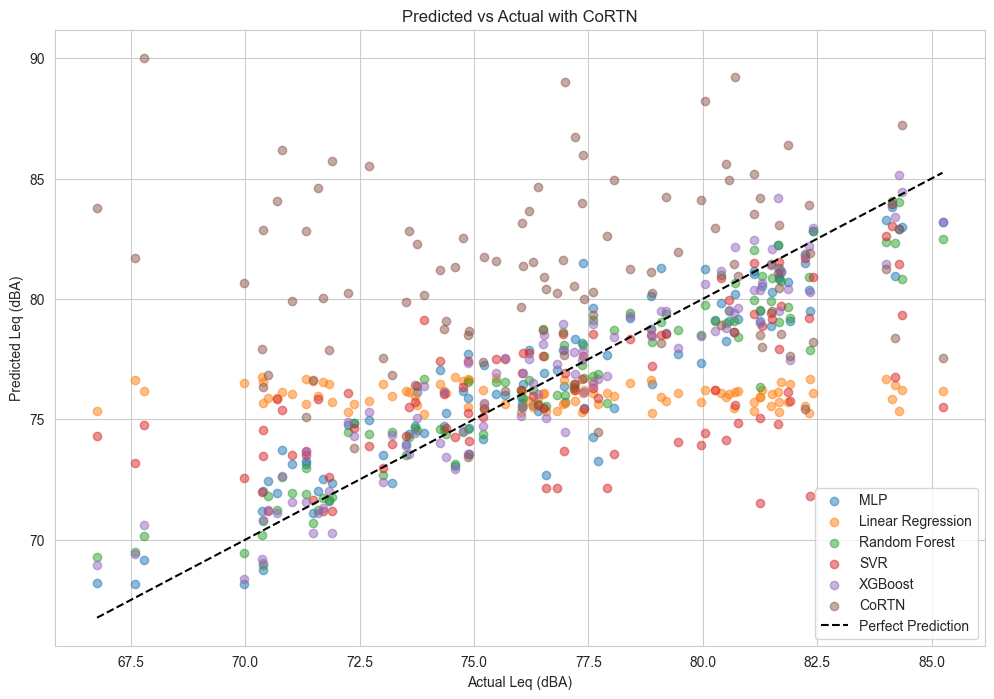

In [19]:
# Load PCU data for flow (Q)
df_pcu = pd.read_excel('data\\FINAL DATA.xlsx', sheet_name='PCU')
pcu_values = df_pcu.iloc[:, 2:].values.flatten()  # Hourly PCU values
speed_values = df_speed.iloc[:, 2:].values.flatten()  # Hourly speed values
lanes_values = [lanes_dict.get(place, 2) for place in df_pcu['Place'].dropna()] * 12  # Repeat for 12 hours

# Approximate CoRTN prediction
def cortn_prediction(q, s, n):
    return 42.2 + 10 * np.log10(q) + 0.16 * s + 10 * np.log10(n) - 5

cortn_preds = [cortn_prediction(q, s, n) for q, s, n in zip(pcu_values, speed_values, lanes_values)]
cortn_preds = np.array(cortn_preds[:len(trues)])  # Match length with test set

# Calculate CoRTN errors
cortn_errors = cortn_preds[:len(trues)] - trues

# Update model dictionary with CoRTN
models.append('CoRTN')
predictions.append(cortn_preds)
errors['CoRTN'] = cortn_errors

# Recalculate performance metrics
metrics = {}
for model, pred in zip(models, predictions):
    metrics[model] = {
        'MAE': mean_absolute_error(trues, pred[:len(trues)]),
        'RMSE': np.sqrt(mean_squared_error(trues, pred[:len(trues)])),
        'R²': r2_score(trues, pred[:len(trues)])
    }

# Print comparison table
print("Performance Comparison with CoRTN:")
for model, m in metrics.items():
    print(f"{model}: MAE = {m['MAE']:.2f} dBA, RMSE = {m['RMSE']:.2f} dBA, R² = {m['R²']:.2f}")

# Update visualizations with CoRTN
plt.figure(figsize=(12, 8))
for model, pred in zip(models, predictions):
    plt.scatter(trues, pred[:len(trues)], alpha=0.5, label=model)
plt.plot([min(trues), max(trues)], [min(trues), max(trues)], 'k--', label='Perfect Prediction')
plt.xlabel('Actual Leq (dBA)')
plt.ylabel('Predicted Leq (dBA)')
plt.title('Predicted vs Actual with CoRTN')
plt.legend()
plt.savefig('predicted_vs_actual_with_cortn.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df_leq = pd.read_excel('data\\FINAL DATA.xlsx', sheet_name='Noise Leq Data')

# Extract numeric values only, converting to numeric and handling errors
measured_leq = df_leq.iloc[:, 2:].values  # Get all hourly data
measured_leq = pd.to_numeric(df_leq.iloc[:, 2:].stack(), errors='coerce').values  # Convert to numeric, coerce errors to NaN
measured_leq = measured_leq[~np.isnan(measured_leq)]  # Remove NaN

# Calculated predictions (use test set predictions extended to match measured data)
calculated_leq = {}

# Example: Add your model predictions (ensure preds is defined)
calculated_leq['MLP'] = np.resize(preds, len(measured_leq))  # Adjust based on your preds array

# Verify the result
print("Cleaned measured Leq values:", measured_leq)

# Calculated predictions (use test set predictions extended to match measured data)
calculated_leq = {}
for model, pred in zip(models, predictions):
    if len(pred) < len(measured_leq):
        # Repeat or interpolate predictions to match measured data length
        calculated_leq[model] = np.resize(pred, len(measured_leq))
    else:
        calculated_leq[model] = pred[:len(measured_leq)]

# Plot Measurement vs Calculation
plt.figure(figsize=(12, 8))
for model, calc in calculated_leq.items():
    plt.plot(range(len(measured_leq)), measured_leq, label='Measured Leq', color='black', alpha=0.5)
    plt.plot(range(len(calc)), calc, label=f'Calculated {model}', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Leq (dBA)')
plt.title('Measurement vs Calculation Results')
plt.legend()
plt.savefig('measurement_vs_calculation.png')
plt.show()

# Bar Plot of Average Differences
avg_diff = {model: np.mean(measured_leq - calc) for model, calc in calculated_leq.items()}
plt.figure(figsize=(12, 6))
plt.bar(avg_diff.keys(), avg_diff.values())
plt.xlabel('Model')
plt.ylabel('Average Difference (Measured - Predicted, dBA)')
plt.title('Average Difference Between Measured and Predicted Leq')
plt.savefig('avg_difference_plot.png')
plt.show()

NameError: name 'preds' is not defined

: 

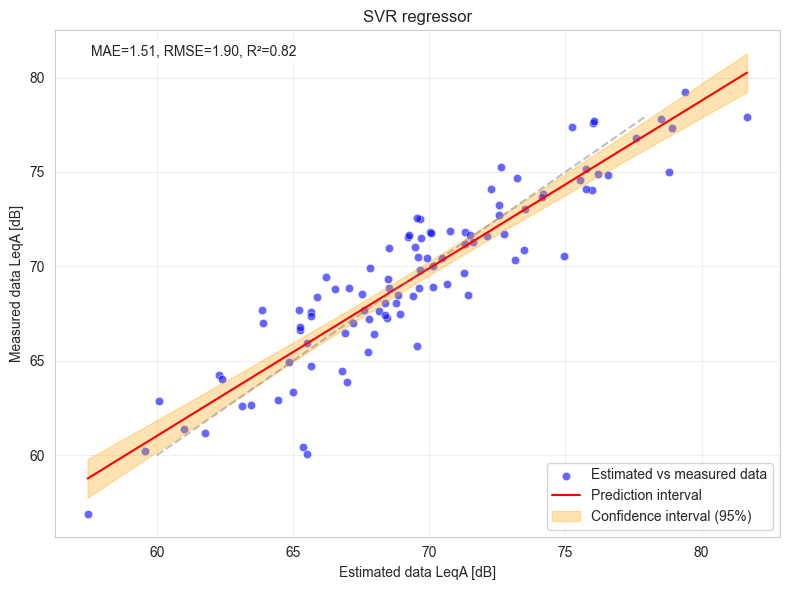

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Sample data (replace with your actual X_test, y_test, and preds_svr)
np.random.seed(42)
n_samples = 100
y_test = np.random.normal(70, 5, n_samples)  # Simulated measured LeqA
preds_svr = y_test + np.random.normal(0, 2, n_samples)  # Simulated predictions with some error

# Ensure data is sorted for plotting the regression line
sort_idx = np.argsort(preds_svr)
preds_svr_sorted = preds_svr[sort_idx]
y_test_sorted = y_test[sort_idx]

# Fit a linear regression for the regression line
X_reg = preds_svr_sorted.reshape(-1, 1)
y_reg = y_test_sorted
reg = LinearRegression().fit(X_reg, y_reg)
y_pred_reg = reg.predict(X_reg)

# Calculate confidence interval (95%)
n = len(y_test)
confidence = 0.95
h = preds_svr_sorted.shape[0]
t = stats.t.ppf((1 + confidence) / 2, h - 2)  # t-score for 95% confidence
residual = y_reg - y_pred_reg
std_error = np.sqrt(np.sum(residual ** 2) / (h - 2))  # Standard error of the estimate
ci = t * std_error * np.sqrt(1/h + (preds_svr_sorted - np.mean(preds_svr_sorted))**2 / np.sum((preds_svr_sorted - np.mean(preds_svr_sorted))**2))
lower_ci = y_pred_reg - ci
upper_ci = y_pred_reg + ci

# Calculate metrics
mae = mean_absolute_error(y_test, preds_svr)
rmse = np.sqrt(mean_squared_error(y_test, preds_svr))
r2 = r2_score(y_test, preds_svr)

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds_svr, y=y_test, color='blue', alpha=0.6, label='Estimated vs measured data')

# Plot regression line and confidence interval
plt.plot(preds_svr_sorted, y_pred_reg, color='red', label='Prediction interval')
plt.fill_between(preds_svr_sorted, lower_ci, upper_ci, color='orange', alpha=0.3, label='Confidence interval (95%)')

# Customize the plot
plt.xlabel('Estimated data LeqA [dB]')
plt.ylabel('Measured data LeqA [dB]')
plt.title('SVR regressor')

# Add metrics annotation
metrics_text = f'MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Add diagonal line (perfect prediction)
plt.plot([60, 78], [60, 78], color='gray', linestyle='--', alpha=0.5)

# Adjust layout and display
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()